In [1]:
from lime import lime_tabular
import pickle
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import hdbscan
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('bases_full.csv')

In [4]:
df = df[[
    'cod_ide', 
    'Cargo',
    'Edad',
    'Genero', 
    'EstadoCivil',
    'nProductividad',
    'nProbMoraNoHeredada', 
    'nProbMoraHeredada',
    'pregunta_1', 
    'pregunta_2', 
    'pregunta_4', 
    'pregunta_5', 
    'pregunta_6', 
    'pregunta_7', 
    'pregunta_8',
    'pregunta_9', 
    'pregunta_10', 
    'pregunta_12',
    'pregunta_13', 
    'pregunta_14', 
    'pregunta_15', 
    'pregunta_16',
    'pregunta_17', 
    'pregunta_18', 
    'pregunta_19', 
    'pregunta_20',
    'pregunta_21', 
    'pregunta_22', 
    'pregunta_23', 
    'pregunta_24',
    'pregunta_26', 
    'pregunta_27', 
    'pregunta_28',
    'pregunta_29', 
    'pregunta_30'
]]

In [5]:
dtypes = ['category', 'bool', 'object']
df_categorical = df.loc[:, [col for col in df.columns]].select_dtypes(include=dtypes)
df_categorical.head()
df_categorical.shape
list(df_categorical)

,cod_ide,Cargo,Genero,EstadoCivil,nProbMoraNoHeredada,nProbMoraHeredada
0,C00000001,ASESOR COMERCIAL FUNCIONARIO,Masculino,Soltero,bueno,malo
1,C00000002,ASESOR COMERCIAL MASTER,Femenino,Otros,malo,malo
2,C00000003,ASESOR COMERCIAL MASTER,Femenino,Casado,malo,bueno
3,C00000004,ASESOR COMERCIAL FUNCIONARIO,Femenino,Soltero,bueno,malo
4,C00000005,ASESOR COMERCIAL FUNCIONARIO,Femenino,Soltero,malo,bueno


(768, 6)

['cod_ide',
 'Cargo',
 'Genero',
 'EstadoCivil',
 'nProbMoraNoHeredada',
 'nProbMoraHeredada']

In [6]:
df = pd.get_dummies(df, columns=['Cargo', 'Genero', 'EstadoCivil'], prefix='D_')

for feature in ['nProbMoraNoHeredada', 'nProbMoraHeredada']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'bueno': 1, 'malo': 0 })

df_categorical = df.loc[:, [col for col in list(df) if 
                            col in list(df_categorical) or 
                            col.startswith('D_') or
                            col.startswith('pregunta')]]

for feature in list(df_categorical):
    if feature != 'cod_ide' and not feature.startswith('pregunta'):
        df[feature].value_counts()

0    417
1    351
Name: nProbMoraNoHeredada, dtype: int64

1    402
0    366
Name: nProbMoraHeredada, dtype: int64

0    707
1     61
Name: D__ASESOR COMERCIAL FUNCIONARIO, dtype: int64

0    611
1    157
Name: D__ASESOR COMERCIAL JUNIOR 1, dtype: int64

0    528
1    240
Name: D__ASESOR COMERCIAL JUNIOR 2, dtype: int64

0    637
1    131
Name: D__ASESOR COMERCIAL MASTER, dtype: int64

0    589
1    179
Name: D__ASESOR COMERCIAL SENIOR, dtype: int64

0    530
1    238
Name: D__Femenino, dtype: int64

1    530
0    238
Name: D__Masculino, dtype: int64

0    621
1    147
Name: D__Casado, dtype: int64

0    676
1     92
Name: D__Otros, dtype: int64

1    529
0    239
Name: D__Soltero, dtype: int64

In [7]:
dtypes = ['number']
df_numeric = df.loc[:, [col for col in df.columns if col not in df_categorical.columns]].select_dtypes(include=dtypes)
df_numeric.head()
df_numeric.shape
list(df_numeric)

,Edad,nProductividad
0,36,0.823077
1,46,0.750000
2,58,0.827303
3,34,1.100000
4,36,0.906250


(768, 2)

['Edad', 'nProductividad']

In [8]:
df_discrete = df.loc[:, [col for col in df_numeric.columns if (df[col].dropna() - df[col].dropna().astype(int) == 0).all()]]
df_discrete.head()
df_discrete.shape
list(df_discrete)

,Edad
0,36
1,46
2,58
3,34
4,36


(768, 1)

['Edad']

In [9]:
df_continuous = df.loc[:, [col for col in df_numeric.columns if col not in df_discrete]]
df_continuous.head()
df_continuous.shape
list(df_continuous)

,nProductividad
0,0.823077
1,0.750000
2,0.827303
3,1.100000
4,0.906250


(768, 1)

['nProductividad']

## Correlations

In [10]:
df['PM'] = df['nProbMoraHeredada'] + df['nProbMoraNoHeredada']

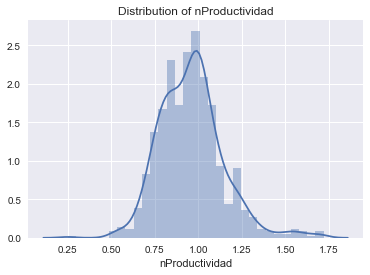

In [11]:
g = sns.distplot(df['nProductividad'])
g.set_title('Distribution of nProductividad')

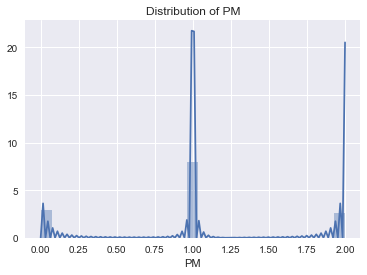

In [12]:
g = sns.distplot(df['PM'])
g.set_title('Distribution of PM')

### Creating target

In [13]:
df['PM'].value_counts()

1    455
0    164
2    149
Name: PM, dtype: int64

In [14]:
def convert_score(el):
    return 1/(el + 1)

In [15]:
df.loc[:, 'PM'] = df.loc[:, 'PM'].apply(convert_score)

In [16]:
df['PM'].value_counts()

0.500000    455
1.000000    164
0.333333    149
Name: PM, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


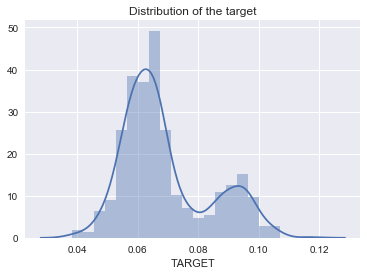

In [17]:
df['N_nProductividad'] = normalize(df['nProductividad'])[0]
df['N_PM'] = normalize(df['PM'])[0]
df['TARGET'] = df['N_nProductividad'] + df['N_PM']
g = sns.distplot(df['TARGET'])
g.set_title('Distribution of the target')

In [18]:
df = df.drop(['PM', 'N_nProductividad', 'N_PM', 'nProductividad', 'nProbMoraHeredada', 'nProbMoraNoHeredada'], axis=1)

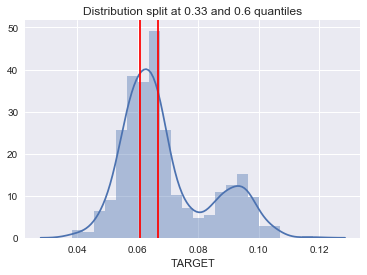

In [19]:
margin1 = 0.33
margin2 = 0.60

g = sns.distplot(df['TARGET'])
g.set_title('Distribution split at {} and {} quantiles'.format(margin1, margin2))
sns.plt.axvline(df['TARGET'].quantile(margin1), color='r')
sns.plt.axvline(df['TARGET'].quantile(margin2), color='r')

plt.show()

In [20]:
df[['cod_ide', 'TARGET']].head()

,cod_ide,TARGET
0,C00000001,0.059532
1,C00000002,0.085980
2,C00000003,0.059688
3,C00000004,0.069756
4,C00000005,0.062603


In [21]:
categories = ['bad', 'normal', 'good']
cuts = [min(df['TARGET']), df['TARGET'].quantile(margin1), df['TARGET'].quantile(margin2), max(df['TARGET'])]
df['TARGET'] = pd.cut(df['TARGET'], cuts, labels=categories, include_lowest=True)

In [22]:
df[['cod_ide', 'TARGET']].head()

,cod_ide,TARGET
0,C00000001,bad
1,C00000002,good
2,C00000003,bad
3,C00000004,good
4,C00000005,normal


In [23]:
df.loc[:, 'TARGET'] = df.loc[:, 'TARGET'].map({
    'bad': 0,
    'normal': 1,
    'good': 2
})
df['TARGET'].value_counts()

2    307
0    258
1    203
Name: TARGET, dtype: int64

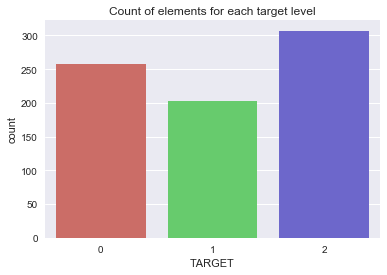

In [24]:
g = sns.countplot(x="TARGET", data=df, palette='hls')
g.set_title('Count of elements for each target level')

In [25]:
df = df.drop(['cod_ide'], axis=1)

In [26]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

In [27]:
X.shape, y.shape

((768, 38), (768,))

# Clustering

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

,Edad,pregunta_1,pregunta_2,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,...,D__ASESOR COMERCIAL JUNIOR 1,D__ASESOR COMERCIAL JUNIOR 2,D__ASESOR COMERCIAL MASTER,D__ASESOR COMERCIAL SENIOR,D__Femenino,D__Masculino,D__Casado,D__Otros,D__Soltero,cluster
0,36,0.210433,0.014503,0.475461,0.191990,0.208157,0.007626,0.853459,0.767801,0.663650,...,0,0,0,0,0,1,0,0,1,1
1,46,0.789044,0.343001,0.926026,0.871500,0.939968,0.929000,0.118791,0.014260,0.663277,...,0,0,1,0,1,0,0,1,0,-1
2,58,0.242838,0.528969,0.489488,0.286807,0.528751,0.501223,0.036598,0.388621,0.108928,...,0,0,1,0,1,0,1,0,0,-1
3,34,0.761830,0.494812,0.524197,0.645303,0.035893,0.909352,0.005753,0.602978,0.487632,...,0,0,0,0,1,0,0,0,1,-1
4,36,0.945418,0.833204,0.857995,0.926111,0.913815,0.609726,0.990892,0.383625,0.903263,...,0,0,0,0,1,0,0,0,1,-1


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

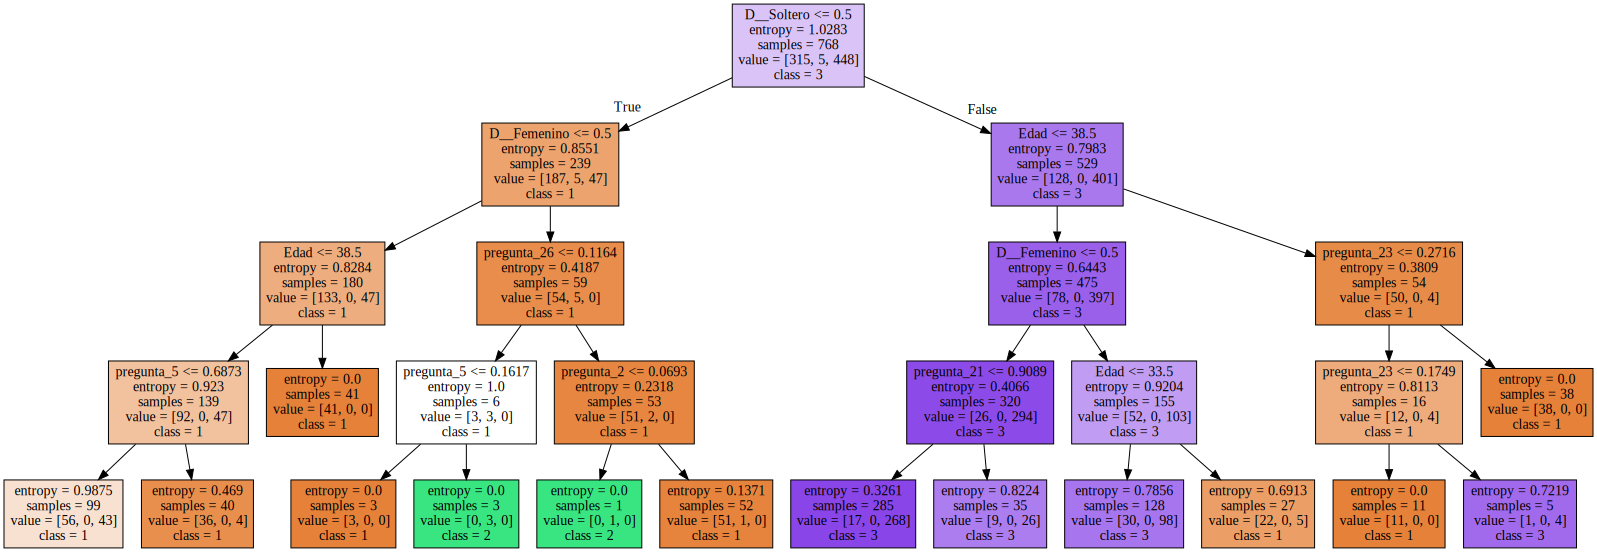

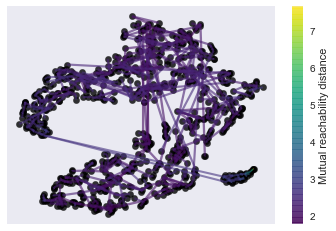

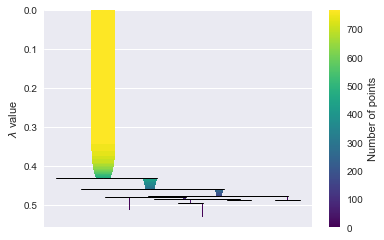

In [28]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
clusterer.fit(X)
plt.figure()
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      edge_linewidth=1)
plt.figure()
clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())



palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
X['cluster'] = pd.Series(clusterer.labels_)
X.head()
y_cluster = X['cluster']
X_cluster = X.drop('cluster', axis=1)

cluster_names = list(range(1, len(X['cluster'].value_counts()) + 1))

dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
dtc.fit(X_cluster, y_cluster)

graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Edad,pregunta_1,pregunta_2,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,...,D__ASESOR COMERCIAL JUNIOR 1,D__ASESOR COMERCIAL JUNIOR 2,D__ASESOR COMERCIAL MASTER,D__ASESOR COMERCIAL SENIOR,D__Femenino,D__Masculino,D__Casado,D__Otros,D__Soltero,TARGET
1,46,0.789044,0.343001,0.926026,0.871500,0.939968,0.929000,0.118791,0.014260,0.663277,...,0,0,1,0,1,0,0,1,0,2
3,34,0.761830,0.494812,0.524197,0.645303,0.035893,0.909352,0.005753,0.602978,0.487632,...,0,0,0,0,1,0,0,0,1,2
6,35,0.221027,0.442683,0.845306,0.073125,0.387089,0.836789,0.340532,0.891033,0.577438,...,0,0,0,0,1,0,1,0,0,2
12,44,0.975351,0.448876,0.514550,0.501630,0.906539,0.949537,0.250857,0.071521,0.703418,...,0,0,1,0,1,0,1,0,0,2
13,46,0.182366,0.394757,0.458081,0.429477,0.107369,0.068157,0.299596,0.081091,0.335981,...,0,0,1,0,1,0,0,0,1,2


1    -1.0
3    -1.0
6    -1.0
12   -1.0
13   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

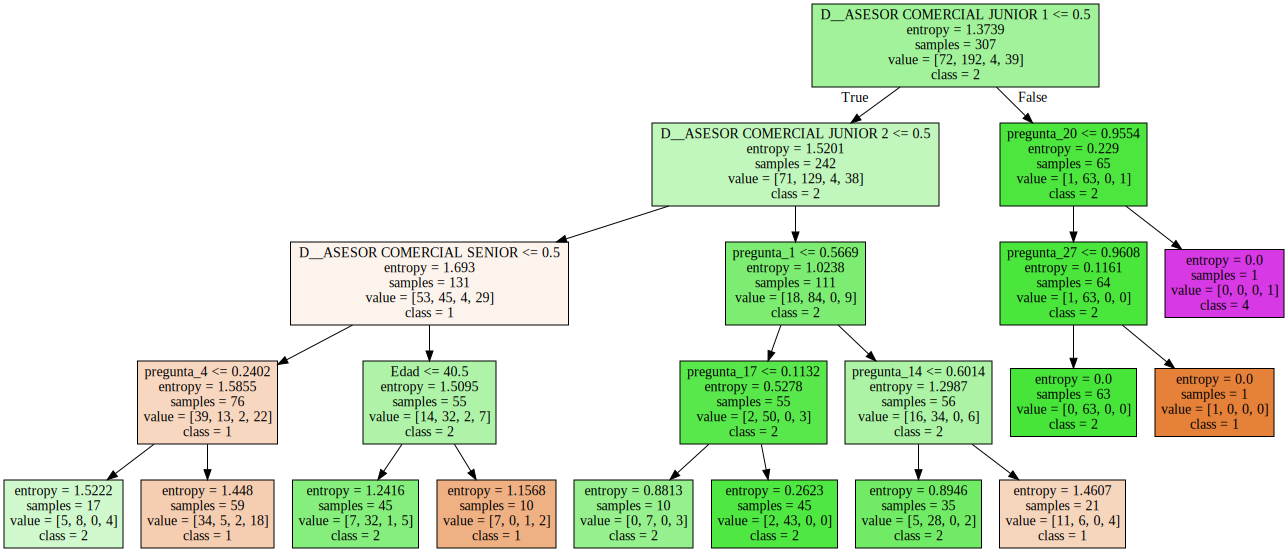

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Edad,pregunta_1,pregunta_2,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,...,D__ASESOR COMERCIAL JUNIOR 1,D__ASESOR COMERCIAL JUNIOR 2,D__ASESOR COMERCIAL MASTER,D__ASESOR COMERCIAL SENIOR,D__Femenino,D__Masculino,D__Casado,D__Otros,D__Soltero,TARGET
0,36,0.210433,0.014503,0.475461,0.191990,0.208157,0.007626,0.853459,0.767801,0.663650,...,0,0,0,0,0,1,0,0,1,0
2,58,0.242838,0.528969,0.489488,0.286807,0.528751,0.501223,0.036598,0.388621,0.108928,...,0,0,1,0,1,0,1,0,0,0
8,41,0.113082,0.217811,0.059313,0.794239,0.425821,0.976964,0.074504,0.635164,0.315065,...,0,1,0,0,0,1,0,1,0,0
9,42,0.872726,0.196752,0.307564,0.941359,0.259736,0.217433,0.567548,0.105543,0.649025,...,0,0,0,1,0,1,0,0,1,0
11,33,0.462763,0.730985,0.622575,0.603140,0.679366,0.042535,0.176089,0.092572,0.330886,...,0,0,1,0,1,0,1,0,0,0


0     1.0
2     1.0
8     1.0
9     1.0
11    1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

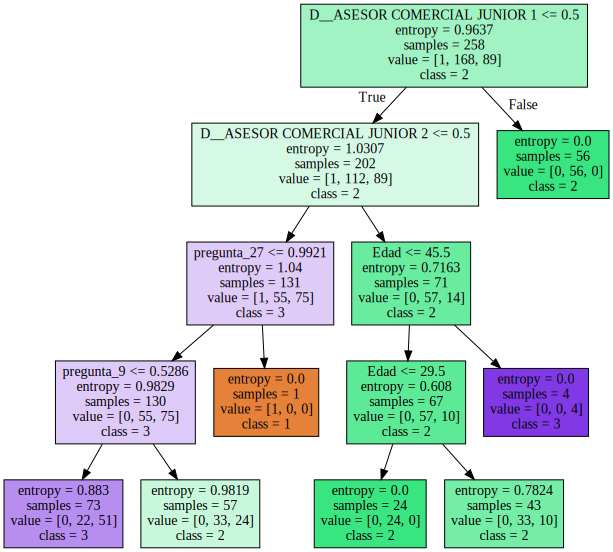

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Edad,pregunta_1,pregunta_2,pregunta_4,pregunta_5,pregunta_6,pregunta_7,pregunta_8,pregunta_9,pregunta_10,...,D__ASESOR COMERCIAL JUNIOR 1,D__ASESOR COMERCIAL JUNIOR 2,D__ASESOR COMERCIAL MASTER,D__ASESOR COMERCIAL SENIOR,D__Femenino,D__Masculino,D__Casado,D__Otros,D__Soltero,TARGET
4,36,0.945418,0.833204,0.857995,0.926111,0.913815,0.609726,0.990892,0.383625,0.903263,...,0,0,0,0,1,0,0,0,1,1
5,43,0.469796,0.874347,0.975214,0.434296,0.976213,0.565399,0.018880,0.230366,0.935261,...,0,0,1,0,1,0,0,0,1,1
7,41,0.137555,0.787741,0.278163,0.120059,0.672811,0.560806,0.962164,0.352382,0.862904,...,0,0,0,0,0,1,0,0,1,1
10,49,0.832347,0.064413,0.915506,0.585383,0.706981,0.259823,0.475864,0.813500,0.070144,...,1,0,0,0,1,0,0,0,1,1
15,32,0.222938,0.129518,0.203387,0.391220,0.027578,0.392845,0.588458,0.979019,0.171502,...,0,0,0,1,0,1,0,0,1,1


4    -1.0
5    -1.0
7     0.0
10   -1.0
15   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

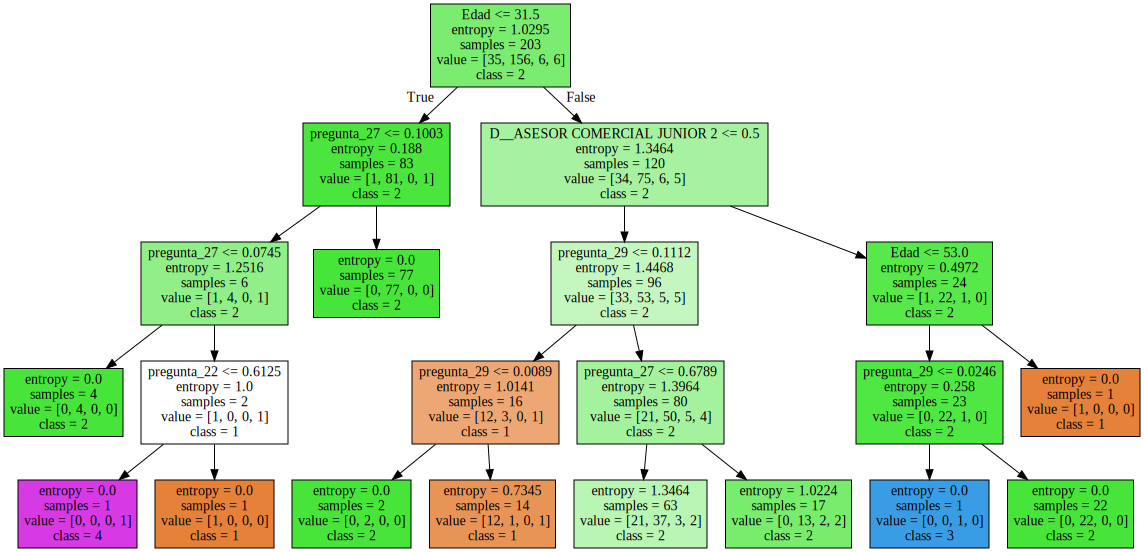

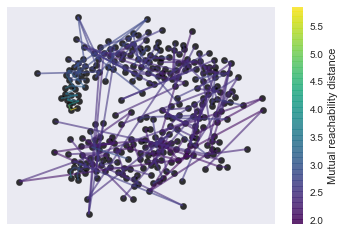

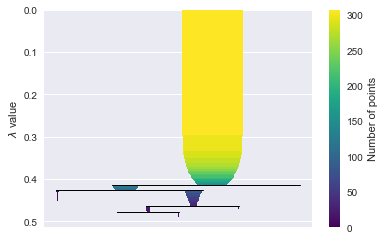

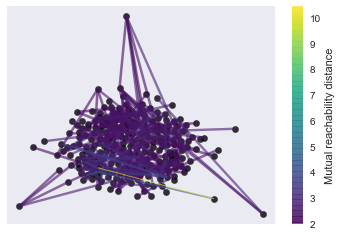

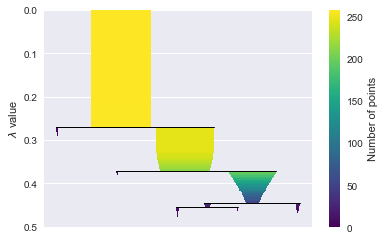

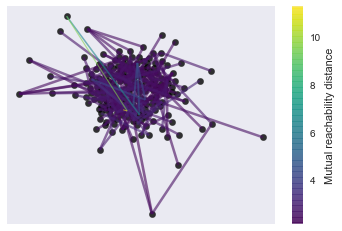

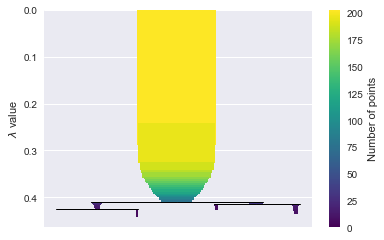

In [29]:
for target_class in list(y.value_counts().index):
    X_target = df.loc[df['TARGET'] == target_class]
    clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
    clusterer.fit(X_target)
    plt.figure()
    clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                          edge_alpha=0.6,
                                          edge_linewidth=1)
    plt.figure()
    clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
    palette = sns.color_palette()
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    X_target['cluster'] = pd.Series(clusterer.labels_)
    y_cluster = X_target['cluster']
    X_cluster = X_target.drop('cluster', axis=1)
    
    X_cluster.head()
    y_cluster.head()
    
    cluster_names = list(range(1, len(X_target['cluster'].value_counts()) + 1))

    dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
    dtc.fit(X_cluster.fillna(0), y_cluster.fillna(0))

    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

    SVG(graph.pipe(format='svg'))

In [30]:
list(y.value_counts().index)

[2, 0, 1]

In [31]:
X.shape, y.shape

((768, 39), (768,))

# Cross-validation

In [32]:
eval_size = 0.1
kf = StratifiedKFold(df['TARGET'], round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [33]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 39), (690,))

((78, 39), (78,))

In [34]:
def increase_value(feature, temp, value):

    before_value = temp.loc[feature]
    after_value = temp.loc[feature] + value

    before = model.predict(temp)[0]
    temp.loc[feature] += value
    after = model.predict(temp)[0]
    
    if sum(before == after) == 0:  
        print('\nIncreasing {}'.format(feature))
        print('From {} to {}'.format(before_value, after_value))
        print('Before: {} (class {})'.format(before, list(before).index(max(before))))
        print(' After: {} (class {})'.format(after, list(after).index(max(after))))

In [35]:
def decrease_value(feature, temp, value):

    before_value = temp.loc[feature]
    after_value = temp.loc[feature] - value

    before = model.predict(temp)[0]
    temp.loc[feature] -= value
    after = model.predict(temp)[0]
    
    if sum(before == after) == 0:  
        print('\nDecreasing {}'.format(feature))
        print('From {} to {}'.format(before_value, after_value))
        print('Before: {} (class {})'.format(before, list(before).index(max(before))))
        print(' After: {} (class {})'.format(after, list(after).index(max(after))))

# Models

In [36]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    }
}

## LightGBM

In [37]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 1,
 'is_unbalance': False,
 'learning_rate': 0.03,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 30,
 'objective': 'multiclass',
 'reg_alpha': 0,
 'reg_lambda': 5,
 'seed': 777,
 'subsample': 0.9}

Recall: 0.5483870967741935
Precision: 0.4473684210526316
Accuracy: 0.3717948717948718


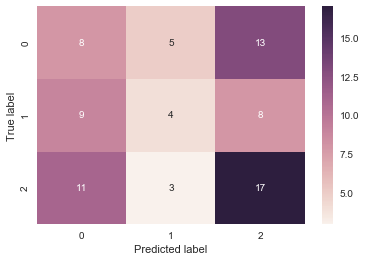

In [38]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

[1]	valid_0's multi_logloss: 1.09716
[2]	valid_0's multi_logloss: 1.09563
[3]	valid_0's multi_logloss: 1.09475
[4]	valid_0's multi_logloss: 1.09284
[5]	valid_0's multi_logloss: 1.09162
[6]	valid_0's multi_logloss: 1.08971
[7]	valid_0's multi_logloss: 1.08892
[8]	valid_0's multi_logloss: 1.08774
[9]	valid_0's multi_logloss: 1.08619
[10]	valid_0's multi_logloss: 1.08457
[11]	valid_0's multi_logloss: 1.08409
[12]	valid_0's multi_logloss: 1.0837
[13]	valid_0's multi_logloss: 1.08192
[14]	valid_0's multi_logloss: 1.08137
[15]	valid_0's multi_logloss: 1.08089
[16]	valid_0's multi_logloss: 1.08054
[17]	valid_0's multi_logloss: 1.07912
[18]	valid_0's multi_logloss: 1.07763
[19]	valid_0's multi_logloss: 1.07771
[20]	valid_0's multi_logloss: 1.07689
[21]	valid_0's multi_logloss: 1.07724
[22]	valid_0's multi_logloss: 1.07623
[23]	valid_0's multi_logloss: 1.07608
[24]	valid_0's multi_logloss: 1.07511
[25]	valid_0's multi_logloss: 1.07511
[26]	valid_0's multi_logloss: 1.07582
[27]	valid_0's multi_l

Recall: 0.6129032258064516
Precision: 0.5135135135135135
Accuracy: 0.44871794871794873


Feature importance based on entropy:
Feature ranking with recursive feature elimination:


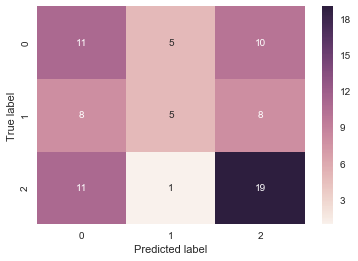

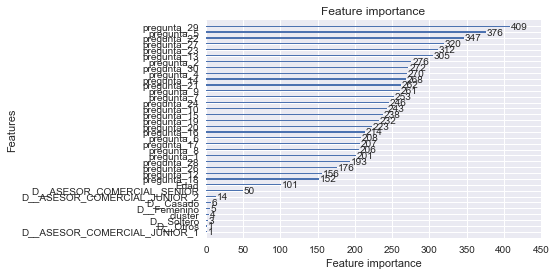

In [39]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)

y_pred = model.predict(X_valid)

y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)

cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['lightgbm']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['lightgbm']['precision'] = precision

accuracy = accuracy_score(y_pred_trunc, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['lightgbm']['accuracy'] = accuracy

lgb.plot_importance(model)

print('Feature importance based on entropy:')
d = dict(zip(model.feature_name(), model.feature_importance()))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['lightgbm']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['lightgbm']['fe_rfe'] = fe_rfe

### LIME using LightGBM

In [40]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict)
exp.show_in_notebook(show_table=True, show_all=False)
temp = X_valid.iloc[i].copy()
for feature in X_valid.columns:
    increase_value(feature, temp, 10)
    decrease_value(feature, temp, 20)


Decreasing Edad
From 47.0 to 27.0
Before: [ 0.22229011  0.29574809  0.4819618 ] (class 2)
 After: [ 0.2276599   0.28080239  0.49153771] (class 2)

Increasing pregunta_1
From 0.18062214489390227 to 10.180622144893903
Before: [ 0.2276599   0.28080239  0.49153771] (class 2)
 After: [ 0.23196392  0.29737757  0.47065851] (class 2)

Decreasing pregunta_1
From 10.180622144893903 to -9.819377855106097
Before: [ 0.23196392  0.29737757  0.47065851] (class 2)
 After: [ 0.22573799  0.28687388  0.48738813] (class 2)

Increasing pregunta_2
From 0.24652130114552076 to 10.24652130114552
Before: [ 0.22573799  0.28687388  0.48738813] (class 2)
 After: [ 0.20408431  0.26436977  0.53154592] (class 2)

Decreasing pregunta_2
From 10.24652130114552 to -9.75347869885448
Before: [ 0.20408431  0.26436977  0.53154592] (class 2)
 After: [ 0.22573799  0.28687388  0.48738813] (class 2)

Decreasing pregunta_4
From 10.947039661346922 to -9.052960338653078
Before: [ 0.22573799  0.28687388  0.48738813] (class 2)
 Afte

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:423: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


## Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 15,
 'n_estimators': 1200}

Recall: 0.5806451612903226
Precision: 0.3829787234042553
Accuracy: 0.34615384615384615


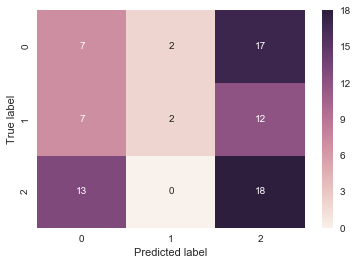

In [41]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=1200, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.5806451612903226
Precision: 0.3829787234042553
Accuracy: 0.34615384615384615
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


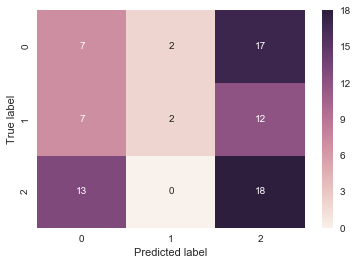

In [42]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['random_forest']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['random_forest']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['random_forest']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['random_forest']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['random_forest']['fe_rfe'] = fe_rfe

### LIME using Random Forests

In [43]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

# Extra Trees

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 1200}

Recall: 0.8387096774193549
Precision: 0.40625
Accuracy: 0.41025641025641024


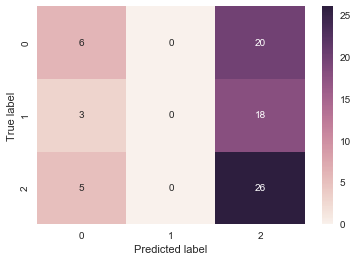

In [44]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=100, min_weight_fraction_leaf=0.0,
           n_estimators=1200, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.8387096774193549
Precision: 0.40625
Accuracy: 0.41025641025641024
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


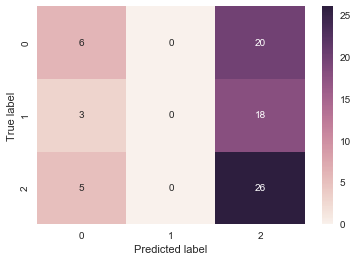

In [45]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['extra_trees']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['extra_trees']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['extra_trees']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['extra_trees']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['extra_trees']['fe_rfe'] = fe_rfe

### LIME using Extra Trees

In [48]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict)
exp.show_in_notebook(show_table=True, show_all=False)
temp = X_valid.iloc[i].copy()
for feature in X_valid.columns:
    increase_value(feature, temp, 10)
    decrease_value(feature, temp, 20)

NameError: name 'X_train' is not defined